# Destiny 2 Exotic Class Item Farm Analysis
*Finnley Autumn Rogers* | 2024-08-01

## Introduction

With the launch Destiny 2's most recent expansion, *the Final Shape*, came the addition of a new piece of armor known as the Exotic Class Item. This was a highly sought after addition to the game's sandbox, as it offered brand new combinations of perks that had not been possible to have together before. Acquiring the armor piece soon became a point of contention within the community, as the methods of actually getting the item were divided between an extremely rare drop from world chests and a guaranteed drop from a 15-20 min two player activity.

I wanted to quickly examine the two methods of acquiring the item to see how long it may take to get a specific drop or to get every drop, giving a good idea of what the grind for this item may look like practically. 

Lets start with a little context on Destiny 2 for people who may not be familiar with the game, or video games in general.

#### Background for non-destiny players

Destiny 2 is an Massively Multiplayer Online First Person Shooter (MMOFPS), where the player is incentivized to complete certain activities in order to recieve randomly generated 'loot', be it weapons or armor. There are three playable Classes that any player can choose (titan, warlock, hunter), and within those classes is a special 'class item', or a piece of armor that can only be worn by that particular class (e.g. Hunter's have cloaks, Warlocks have armbands, and Titans have a 'mark'). 


Each piece of armor can have different rarity values, where 'Exotic' is the rarest. Exotic armor provides a singular, powerful, unchanging, benefit (perk) for wearing, and as a result, only one piece of exotic armor can be worn at a time. 

This particular item, the Exotic Class item can be obtained from two different sources (I'll discuss that more later), and offers a combination of two pieces of exotic armor. Each Class gets their own version of this item, with slightly different perks available to each class. Below are in game screenshots of each exotic class item (sourced from [light.gg](https://www.light.gg/))

Titan Mark

<img src='images/stoicism.jpg' style ="width: 500px"/>

Hunter Cloak

<img src='images/relativisim.jpg' style ="width: 500px"/>

Warlock Armband

<img src='images/solipsism.jpg' style ="width: 500px"/>

What makes this so unique is that, unlike usual exotic armor, the perks available on each class item are randomly selected each time the item is attained (typically referred to as a 'drop'). There are 2 perk 'columns', with 8 perks that can possibly appear in each column, for 64 total versions of the Exotic Class item *per class* (for a total of 192 variants across all classes).

Because of the potency of certain perk combinations, and the ever changing nature of an always-online video game, many different combinations are seen as desirable either to facilitate various playstyles, or simply from a completionist perspective. As such, the sources of the Class Item are heavily scrutinized by the playerbase, to reach an understanding of the 'most efficient' way to get a Class Item drop. 

In broad strokes there are two kinds of players pursuing different rolls of the Exotic Class Item.
1. Completionists: Players who will continue to grind until they have recieved all 64 possible versions of the item
2. Targeted Runners: Players who are looking for one specific combination of perks, and will stop pursuing the item once received.

Those are the two player cases I will examine in the rest of this analysis. 

I would like to acknowledge that at the time of this analysis being created, the developer of the game, Bungie, has announced upcoming changes to the drop rates that will instantly make this analysis out of date. As such, I am creating this as more of an exercise in Statistical analysis, and because I'm honestly a little curious about what this grind acutally looks like.

## First Steps

To begin, I need to establish the baseline probabilities. 

I would like to assume the following:
- Each perk has a uniform probability of dropping, presumably $\frac{1}{8}$
    - By extension, any given drop of a Class Item has a $\frac{1}{64}$ chance of appearing.
- Each column is independent of one another
    - the perks that drop in column 1 have no influence on the perks that drop in column 2.

This is all pretty cut and dry binomial. 

To be statistically rigorous, we should test our assumptions. Some brave souls compiled the data for hundreds of Exotic Class item drops in a reddit thread [here](https://old.reddit.com/r/DestinyTheGame/comments/1ec8ewt/in_light_of_the_upcoming_exotic_class_item/). Using this data, we can test the drop rate assumption, but unfortunately not the independence assumption as the data is only available as totals, and not per drop.

The only way I can think to test indepence would involve an absurd amount of destiny playtime, which I unfortunately do not have time to do. The only way I can think to proceed then, is to just assume that the two columns are independent. This is **not** a sound idea, but for a statistical exercise I'm making on the side over some weekends I would say it's fine. 

We can begin by loading the parsed dataset based on the numbers given in the above reddit thread. 

All data used in this analysis will be available in the ```data/``` folder in this repository.


In [1]:
from statsmodels.stats.proportion import binom_test
from scipy.stats import f_oneway, normaltest
from scipy.stats._discrete_distns import geom

import pandas as pd
import numpy as np

np.random.seed(42) # for consistency

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
perk_drops = pd.read_csv("data/perk_drops.csv")
perk_drops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_item   48 non-null     object
 1   perk_column  48 non-null     int64 
 2   perk_name    48 non-null     object
 3   drops        48 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.6+ KB


In [3]:
perk_drops.head(2)

,class_item,perk_column,perk_name,drops
0,hunter,1,Assassin,21
1,hunter,1,Inmost Light,23


In [4]:
for player_class in perk_drops.class_item.unique():
    print(player_class)
    print(perk_drops[perk_drops.class_item == player_class][['perk_column', 'drops']].groupby('perk_column').sum().reset_index())

hunter
   perk_column  drops
0            1    182
1            2    182
warlock
   perk_column  drops
0            1    161
1            2    161
titan
   perk_column  drops
0            1    287
1            2    287


This all checks out - since once perk from each column appears in every drop we should be seeing matching totals for each column. 

Now lets check on our assumptions of this data. 

There are 2 assumptions that will need to be checked if possible. 
1. The drops in each column are *independent* of each other (what drops in column 1 has no influence on what drops in column 2)
    - As mentioned above, I do not have any data to test this assumption unfortunately. For the purposes of this exploratory/practice analysis, I'm proceeding on the assumption that **the two perk columns are independent**
2. Each perk has a $\frac{1}{8}$ probability to drop, for a $\frac{1}{64}$ total probability for any given class item drop.
    - I do have data to test this, based on the reddit post linked above.

Now I can proceed with a binomial proportion test (```binom_test``` from ```statsmodels```)

I can also go ahead and establish the sample parameters:

$E(x) = np$

$\sigma^2(x) = np(1-p)$

where p = 0.125 = $\frac{1}{8}$

This give us the following:

| Class Name | $E(x)$ | $\sigma^2(x)$ | $\sigma(x)$ | 
| --- | --- | --- | --- |
| Hunter | 22.75 | 19.91 | 4.46 |
| Warlock | 20.13 | 17.61 | 4.2 |
| Titan | 35.88 | 31.39 | 5.6 |

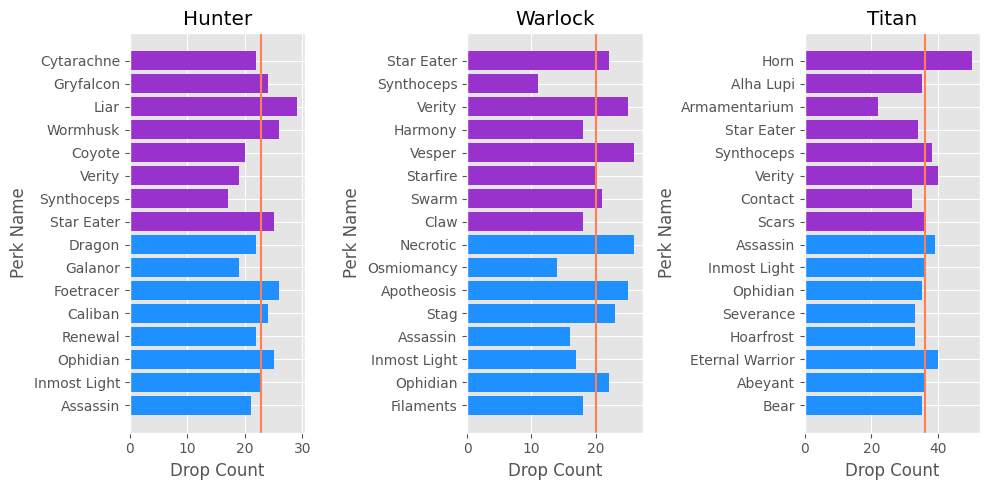

In [5]:
expected = {
    'hunter': 22.75,
    'warlock': 20.13,
    'titan': 35.88
}

fig, ax = plt.subplots(nrows=1,ncols=3, tight_layout = True, figsize=(10,5))

for player_class in perk_drops.class_item.unique():
    temp = perk_drops[perk_drops.class_item == player_class]

    ind = list(perk_drops.class_item.unique()).index(player_class)

    bar_colors = temp.perk_column.map({1:'dodgerblue', 2:'darkorchid'})

    

    ax[ind].barh(temp.perk_name, temp.drops, label = temp.perk_column, color = bar_colors)

    ax[ind].set_title(f"{player_class.title()}")
    ax[ind].set_ylabel("Perk Name")
    ax[ind].set_xlabel("Drop Count")

    # add line for expected value
    ax[ind].axvline(x = expected[player_class], color = 'coral')

plt.savefig(f"outputs/all_classes_perk_drops_bar.png")
plt.show()

The majority of these perks are within 1 standard deviation of the expected number of drops, tenatively, without any testing, I would say its reasonable to assume our 1/8 probability for the whole dataset. 

Now for each of the perks, lets run a binomial proportion test to see if their drop rates are significantly diffrerent than $\frac{1}{8}$

$H_{0} = p_{1} - p_{0} = 0$

$H_{a} = p_{1} - p_{0} \neq 0$

where $p_{1} = p_{perk drop rate}$ and $p_{0} = 0.125$

For this, given the slightly smaller sample and that this is not a rigorous analysis, I'm fine with a lower confidence level, so I'll use $\alpha = 0.1$

I'm essentially only looking to see if I find any evidence to reject my null hypothesis at all. 

In [6]:
p_values = []

for player_class in perk_drops.class_item.unique():
    temp = perk_drops[perk_drops.class_item == player_class]

    # number of observations
    n_obs = int(sum(temp.drops) / 2)

    # for each perk run the test and save the pvalue
    for perk in temp.perk_name:
        p_values.append(binom_test(
            temp[temp['perk_name'] == perk].drops.item(),
            n_obs,
            0.125 
        ))


In [7]:
perk_drops['p_values'] = [round(float(x), 4) for x in p_values]

perk_drops['significant'] = [True if x < 0.1 else False for x in p_values]

In [8]:
perk_drops.head(2)

,class_item,perk_column,perk_name,drops,p_values,significant
0,hunter,1,Assassin,21,0.8224,False
1,hunter,1,Inmost Light,23,0.9109,False


In [9]:
perk_drops[perk_drops.significant == True]

,class_item,perk_column,perk_name,drops,p_values,significant
30,warlock,2,Synthoceps,11,0.0310,True
45,titan,2,Armamentarium,22,0.0121,True
47,titan,2,Horn,50,0.0156,True


Hmm ok, I am able to find evidence to reject my null hypothesis for three perks, two from the Titan class, and one from Warlocks. For every other perk, I do not have sufficient evidence to think that the drop rate would be different from $\frac{1}{8}$.

All three would be rejected at a 99% confidence, but changing your confidence mid test is... frowned upon.

My thought is to go forward with my $p(perkdrop) = \frac{1}{8}$ assumption regardless for the following reasons:

1. It's only 3 perks. Out of 16 for each class (48 total). There's no reason to think that these three specifically have different drop rates. Especially since;
2. The Hunter class isn't represented. I was not able to find evidence that *any* of the Hunter perks were significantly different than the $\frac{1}{8}$ drop rate assumption. 
3. It makes no sense. I think if one perk out of each class had a slightly different drop rate I would proceed differently. But since it appears to be three semi-random selections I'm more inclined to believe it's just some bad luck. Each perk's p-value not being outrageously high gives me more comfort in that decision.

## Testing conclusion

I am not able to test independence between the two perk columns as I do not have access to a reliable dataset with that information. However I believe that I was able to establish that each perk has a $\frac{1}{8}$ chance of dropping individually, for a combined $\frac{1}{64}$ chance of any given perk combination. 

## Chest Drop Rate and "Lockouts"

Before getting into simulations, we need to look at one more thing.

There are 2 sources of this exotic class item, with different drop rates for each. The first is the mission *Dual Destiny*, which, if completed, has a 100% item drop rate. The second is chests radomly placed around around the Pale Heart area. These chests have an extremely low chance of dropping an item - theorized by the community to be around 2% - 2.5%.

A reddit user farmed 99 of these class items from world chests (33 for each class), posting the data to a reddit thread [here](https://old.reddit.com/r/DestinyTheGame/comments/1dwuj5p/i_farmed_99_class_items_from_pale_heart_chests/). The recorded data is split between three classes again (presumably the data is gathered one character per class), and records the drop number, and the number of drops since the previous one. I've converted this into a csv file for easier use in jupyter. You can find that csv in the data folder of this github. 

Given the low drop rate of the item from these world chests, its been hypothesized by the community that drop "lockouts" exist. Such a system would essentially prevent a player from receiving a drop from a world chest "too quickly". Nothing else is known about such a system, just that there may be a period of real world time or 

**Assumptions**
- Each chest is independent
    - My assumption here is based on a developer update that indicated that "drop protections" would be added in a future update (e.g. the chance of the item dropping would increase until the player got a drop, then resetting to a baseline value and repeating until the next drop)
- The drop rates are the same across classes.
    - I can examine this using the data provided


In [10]:
world_chests = pd.read_csv("data/world_chests.csv")
world_chests.head(2)

,player_class,drop_no,opened_since_previous_drop,total_chests
0,hunter,1,46,46
1,hunter,2,45,91


In [11]:
world_chests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   player_class                99 non-null     object
 1   drop_no                     99 non-null     int64 
 2   opened_since_previous_drop  99 non-null     int64 
 3   total_chests                99 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 3.2+ KB


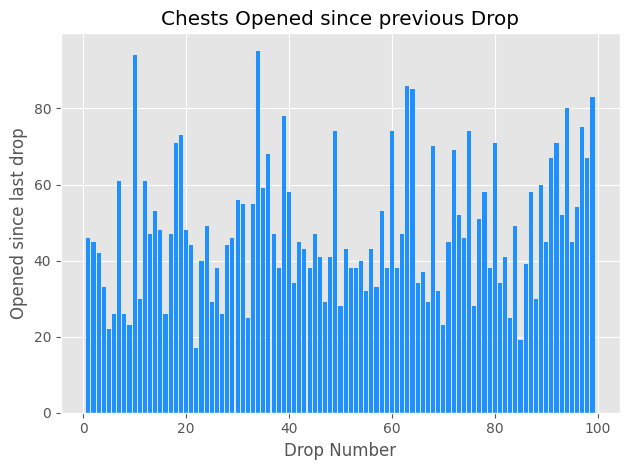

In [12]:
fig,ax=plt.subplots(1,1, tight_layout = True)
ax.bar(world_chests.drop_no, world_chests.opened_since_previous_drop, color = 'dodgerblue')

ax.set_title("Chests Opened since previous Drop")
ax.set_xlabel("Drop Number")
ax.set_ylabel("Opened since last drop")

plt.savefig("outputs/opened_since_last_drop.png")
plt.show()

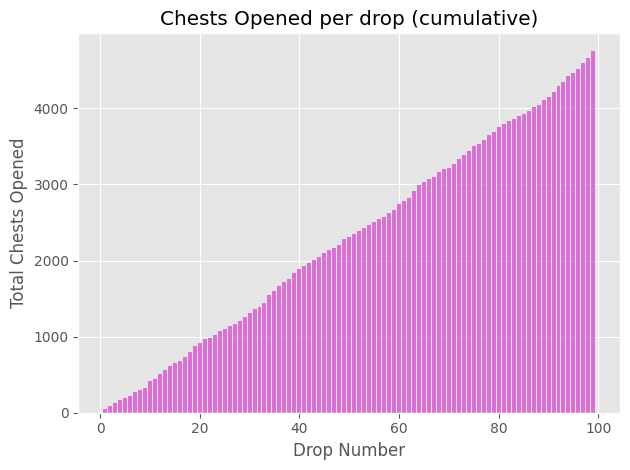

In [13]:
fig,ax = plt.subplots(1,1, tight_layout=True)
ax.bar(world_chests.drop_no, world_chests.total_chests, color = 'orchid')

ax.set_title("Chests Opened per drop (cumulative)")
ax.set_xlabel("Drop Number")
ax.set_ylabel("Total Chests Opened")

plt.savefig("outputs/opened_chests_cumulative.png")
plt.show()

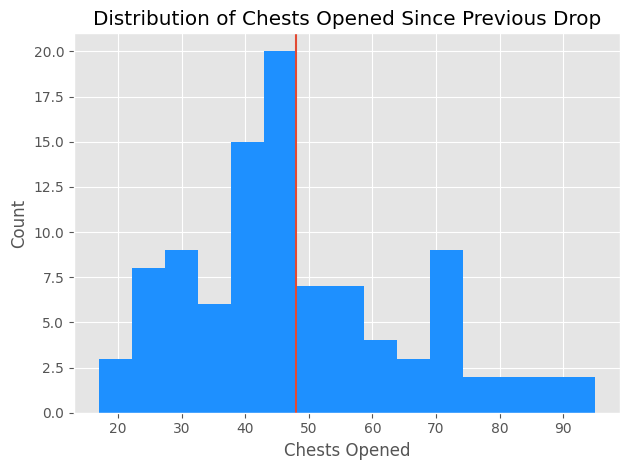

In [14]:
fig,ax=plt.subplots(1,1,tight_layout=True)

ax.hist(world_chests.opened_since_previous_drop, 
        bins = 15,
        color = 'dodgerblue')

ax.axvline(world_chests.opened_since_previous_drop.mean())

ax.set_title("Distribution of Chests Opened Since Previous Drop")
ax.set_ylabel("Count")
ax.set_xlabel("Chests Opened")

plt.savefig("outputs/chests_opened_since_prev_distn.png")
plt.show()

In [15]:
normaltest(world_chests.opened_since_previous_drop)

NormaltestResult(statistic=np.float64(6.35562114440138), pvalue=np.float64(0.04167680365570491))

I want to pause here for a second, as this is *not* what I would expect. This distribution does not look at all like what you would see from a flat drop rate. For reference, here is a simulated distribution of the number of chests opened for 99 drops at a flat 2.5% drop rate.

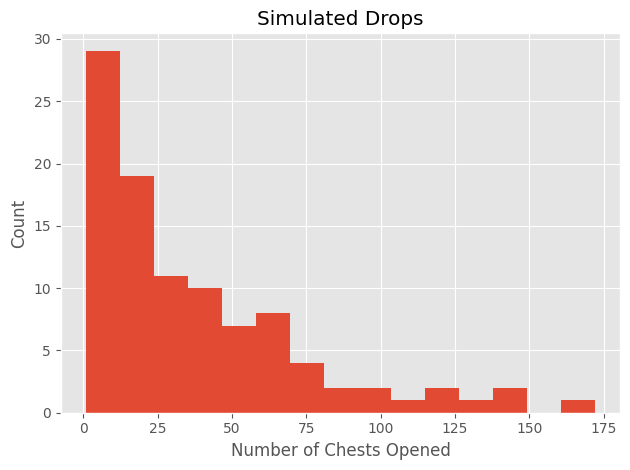

In [16]:
fig,ax = plt.subplots(1,1, tight_layout=True)
samples = list(np.random.geometric(p=0.025, size = 99))

ax.hist(samples, bins = 15)

ax.set_title("Simulated Drops")
ax.set_xlabel("Number of Chests Opened")
ax.set_ylabel("Count")

plt.savefig("outputs/simulated_chests.png")
plt.show()

This simulated distribution is far less 'normal-looking' than the actual data. Looking at the actual data, the drop rates appear to be manipulated to prevent *both* lucky and unlucky outcomes, artificially moving the expected number of opened chests to around 40, and disallowing some expected outcomes like drops from consecutive chests.

#### Brief aside on consecutive drops

If the world chest drop rate is actually a flat rate, what *is* the probability that we don't see a consecutive drop *at all*? 

Well, the probability of getting a drop in consecutive chests is:

$$
p(consecutiveDrops) = p(drop)^2 = 0.025^2 = 0.000625
$$

There are $n-1$ consecutive chests (e.g. ${(1,2), (2,3), (3,4), ... , (n-1, n)}$)

The probability of not getting a drop in consecutive chests is:

$(1 - 0.000625)^2 = 0.99875$

The probability of not getting a drop in a single consecutive chest over 4747 consecutive chests is then:

$0.99875^{n-1} = 0.99875^4747 = 0.00264$

Around a 0.26% chance to never see a consecutive class item drop in 4747 pairs of consecutive chests. Lets leave it at exceedingly rare.

This, combined with the observations about the distribution of chests talked about above makes for pretty compelling evidence that there is, at minimum, some kind of system manipulating drop rates. Whether that's a timed lockout, or just good/bad luck prevention I can't say, but it does prevent me from being able to say in good faith that the chest drop rate is a flat rate at all.

### Hypothesis Testing Conclusions

At the end of all of this we can confidently say that we have evidence for only the following:

1. $p(perk) = \frac{1}{8}$ and by extension, $p(anyClassItemRoll) = \frac{1}{64}$

Now we can explore some simulations of class item farms to establish how long it may take to get every possible combination, or to get a specific roll. 

## Simulations

As I mentioned in the introduction, there are generally 2 kinds of players farming for exotic class item rolls.

1. Players looking to get every variant of the item
2. Players looking for a specific combination of perks (1 specific variant)

In this section I will examine both cases, looking at the average amount of time it would take to achieve either one of the success conditions from both of the sources of the Class Item.

### Completionist Simulations

For those players looking to get all 64 variants for their chosen class - how many drops would it take, on average, to get all of those?

We can think of this as rolling a gigantic 64-sided die (statisticians and their dice...) and stopping when we've seen every number. This is brute-forceable through python, but I'm gonna dust off my brain a little and do some actual statistics.

To start, the probability of getting a variant we've never seen on the first drop is $\frac{64}{64}$. That probability is going to decrease as we get more rolls - the probability of getting the second unique variant is $\frac{63}{64}$, third is $\frac{62}{64}$, and so on, until the last remaining variant at $\frac{1}{64}$. 

We can think of each of these scenarios as its own geometric distribution with a probability of success $p = \frac{remainingVariants}{64}$

The geometric distribution has an expected value $E(x) = \frac{1}{p}$ meaning, linearly, the expected number of drops to get every class item comes out to:

$$
\frac{64}{64} + \frac{64}{63} + \frac{64}{62} + ... + \frac{64}{1} = \sum_{k=1}^{64} \frac{64}{k}
$$




In [17]:
fin = 0
for i in range(1, 65):
    fin = (64/i) + fin

fin

303.6090178371691

Which computes to a little over 303 drops. 

Now lets make a simulation! I'll be looking at how many rolls it takes to see every possible combination.

In [18]:
def completionist_sim(n_players):
    '''
    # completionist_sim

    simulates drop outcomes for n completionist players

    ## inputs 
    - n_players (int): number of players to simulate

    ## returns
    - total_rolls (list): all outcomes for each player
    '''

    total_rolls = []    # list of the total number of rolls in all sims

    for sim in range(n_players):
        # each loop is a new simulation of a completionist player
        # the sim will run until all 64 variants are found, or 100,000 drops
        # without seeing all variants

        num_rolls = 0                           # number of rolls in ongoing simulation
        variants_remaining = list(range(1,65))  # rest the variants remaining

        while len(variants_remaining) > 0:

            # generate variant
            cur_drop = np.random.randint(1, 65)

            # if the variant has not been seen, cross it
            # off the list
            if (cur_drop in variants_remaining):
                variants_remaining.remove(cur_drop)
            
            num_rolls = num_rolls + 1

            # end param adjust as needed
            if num_rolls > 100000:
                variants_remaining = []

        total_rolls.append(num_rolls)

    return total_rolls

In [21]:
sim_10000 = completionist_sim(10000) # simulate 10,000 players

In [22]:
print(f"Mean: {np.mean(sim_10000)}")
print(f"Max: {max(sim_10000)}")
print(f"Min: {min(sim_10000)}")

Mean: 303.9148
Max: 853
Min: 144


A simulation of 10,000 completionist players gives us an average of 303.9 drops to see every variant - nearly dead on the estimation done by hand above! 

The distribution of players in this simulation looks as follows:

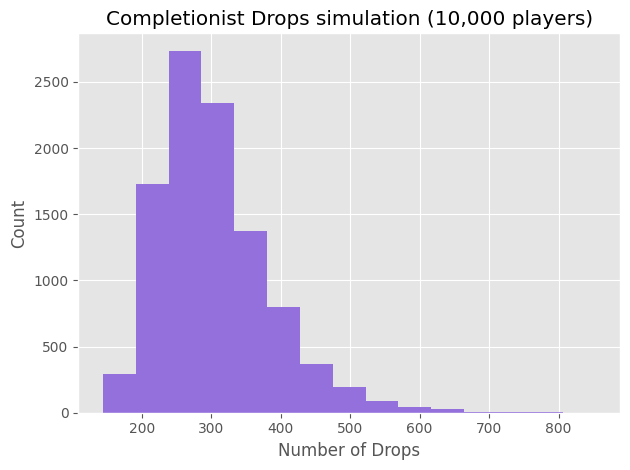

In [25]:
fig,ax=plt.subplots(1,1,tight_layout=True)

ax.hist(sim_10000, bins = 15, color='mediumpurple')

ax.set_title("Completionist Drops simulation (10,000 players)")
ax.set_ylabel("Count")
ax.set_xlabel("Number of Drops")

plt.savefig("outputs/sim_10000.png")
plt.show()

There is a tail of players taking well over 400 drops to see every variant, but the vast majority of players in this simulation see every variant after around 250-350 drops. 

Taking this into context - what does 303 drops feel like? What does this mean practically? Based on some napkin math and the chest data from above, we can say the drops are weighted to take around 40 chests to get another drop, meaning it would take around 12,000 chests to get to reach 303 exotic class item drops. This has changed in a recent update, and there are different systems in place for chests that data is not currently available for, so what about the other source? The mission *Dual Destiny* with a 100% drop rate?

*Dual Destiny* is a fairly short 2 player mission that, if both players know what theyre doing, can take anywhere from 15 to 20 minutes to complete. Assuming our average of 303 drops to get every variant, that would mean 75 to 100 hours of *just this mission* (this is excluding the weekly bonus, which rewards and extra class item once per week). 

In terms of time commitment, I (unfortunately) can say I've seen worse. The hurdle for many will be that it's a 2 player only mission, so getting a friend willing to grind would be the difficult part. 

At this point I should remind you that these numbers apply to only one class at a time. If a player truly wanted to collect all 64 class items across all 3 classes, they'd be looking at an average of 909 drops for 225 to 303 hours (each class item grind is independent since you cannot receive drops for different classes). I truly believe that there are players out there that will want to do this, however I also believe that those players are a vanishingly small minority of the player base. 

So that's the completionists. It's a ridiculous grind, but by design. Not every variant of the exotic class item is useful or even very desirable, so what about the people that just want that one variant? The people that will actually give up once they've gotten their desired variant (or just a singular perk)?

### Targeted Farming Simulations

This is quite a bit simpler. We just want to know, on average, how long is it going to take to get one variant?

Again we are looking at a geometric distribution. There is no duplicate protection (that we're aware of) and there's no elimination, so our probability of success is set at $P_{variant} = \frac{1}{64}$, so our distribution is simply:

$$
geom(\frac{1}{64})
$$

by extenstion the expected number of drops to get the said variant is:

$$
E(x) = \frac{1}{p} = 64
$$

Simple enough. 64 drops, on average, to get that one variant. Lets make another simulation to see how this would theoretically play out for some hypothetical Destiny players.

In [33]:
def targeted_sim(n_players):
    '''
    # targeted_sim

    simulates drop outcomes for n targeted farm players

    ## inputs 
    - n_players (int): number of players to simulate

    ## returns
    - (list): all outcomes for each player
    '''

    return list(np.random.geometric(1/64, n_players))

    

In [34]:
geom_sim = targeted_sim(10000)

In [36]:
print(f"Mean: {np.mean(geom_sim)}")
print(f"Max: {max(geom_sim)}")
print(f"Min: {min(geom_sim)}")

Mean: 64.3445
Max: 580
Min: 1


Again, our hand calculated mean is basically dead on the simulated mean! The distribution of players also has much more skew than the completionist group.

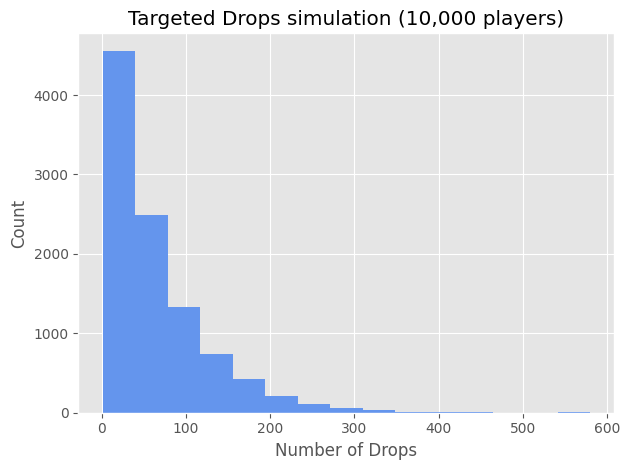

In [35]:
fig,ax=plt.subplots(1,1,tight_layout=True)

ax.hist(geom_sim, bins = 15, color='cornflowerblue')

ax.set_title("Targeted Drops simulation (10,000 players)")
ax.set_ylabel("Count")
ax.set_xlabel("Number of Drops")

plt.savefig("outputs/targeted_sim_10000.png")
plt.show()

The minimum of 1 is expected, some players get lucky! The maximum of 580 is an eye watering number. On average most players would have seen every single variant in the game drop before this player sees the single variant they were chasing. Just an extraordinarily bad piece of luck.

What about players that want just a single perk? After all, the exotic class item makes some perks available to classes that otherwise would not be able to access it (Synthoceps for Hunters/Warlocks, Assassin for Warlocks/Titans, etc). 

In this scenario, a player is only concerned with the perks from a single column, increasing the probability of success to $P_{variant} = \frac{1}{8}$, and making another geometric distribution: 

$$
geom(\frac{1}{8})
$$

by extenstion the expected number of drops to get a specific perk is:

$$
E(x) = \frac{1}{p} = 8
$$

again, looking at how this plays out in 10,000 simulated players:

In [39]:
geom_sim_perk = list(np.random.geometric(1/8, 10000))

print(f"Mean: {np.mean(geom_sim_perk)}")
print(f"Max: {max(geom_sim_perk)}")
print(f"Min: {min(geom_sim_perk)}")

Mean: 8.0321
Max: 74
Min: 1


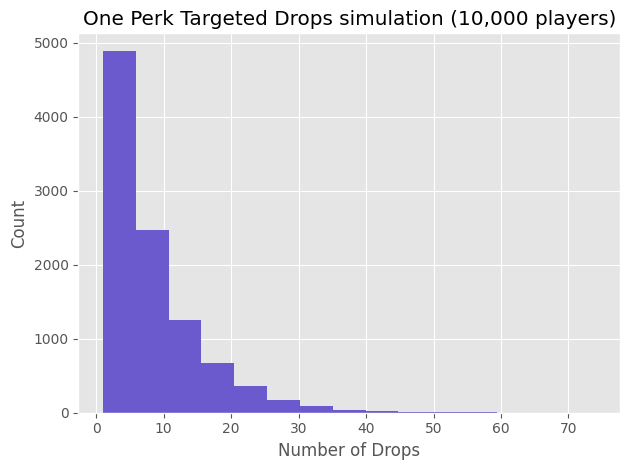

In [42]:
fig,ax=plt.subplots(1,1,tight_layout=True)

ax.hist(geom_sim_perk, bins = 15, color='slateblue')

ax.set_title("One Perk Targeted Drops simulation (10,000 players)")
ax.set_ylabel("Count")
ax.set_xlabel("Number of Drops")

plt.savefig("outputs/targeted_sim_10000_one_perk.png")
plt.show()

Nothing super notable here, most players getting their desired perk within 10 drops, and one particularly unlucky player taking 74 drops to find a single desired perk. Essentially the same distribution shape as the previous geometric simulations.

## Conclusions

So what did we learn? 

The lack of any duplicate protections, or any way to increase the drop rate of a specific perk makes the chase for a specific roll or every roll a long and exhausting process. 303 drops on average to see every roll, and 64 drops on average to see a specific roll are such huge numbers that require such a time commitment that I start wondering if this was ever meant to be focus farmed the way the playerbase seems to want. 

This all seems in line with Bungie's typical attitude towards grinding in Destiny 2 - login a few times a week to get a new chance at an item, then come back next week. This is seen in nearly every activity in the game, from powerful drops in the first completion of specific raids each week to story events delivered in pieces weekly. Cynically speaking it's a way to boost player retention numbers over time, essentially 'turning off the faucet' to reward players for coming back weekly instead of freely allowing players to acquire everything in a shorter timeframe. It's also likely a healthier option to prevent player burnout and discourage your typical "never leaves the house" gamer stereotype. In fact, while I was putting this together, Bungie added a guaranteed extra drop from the Dual Destiny mission once a week.

This was a fun little project to throw together in my free time, I'm sure it will be outdated in no time as the nature of live service games goes.